# Portfolio-Exam 

#### Imports

In [1]:
# Imports 

# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Sklearn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import metrics as ms
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Tensorboard
from torch.utils.tensorboard import SummaryWriter

#### Set Variables

In [2]:
random_seed = 42                     # Set random seed for reproducibility
torch.manual_seed(42)                # Set torch seed for reproducibility
torch.set_default_dtype(torch.float) # Set default tensor type to float

## Task 1 - Story

#### Context and Purpose

As a data scientist at a leading bank, I'm tasked with improving the bank's credit risk assessment process. The bank is committed to reduce the risk of defaults. Accurate credit risk assessment is crucial for the bank to minimize losses and ensure financial stability. The objective of your this experiment is to develop a classification model that can effectively distinguish between good and bad credit applicants based on historical data.

#### Scenario 

The bank provided me a dataset containing information about previous credit applicants. This dataset includes various attributes such as the applicant's credit history, loan amount, duration, and personal information. The goal is to use this data to train a model that can predict the creditworthiness of new applicants. By accurately identifying high-risk applicants, the bank can take preventive measures such as requiring additional security, adjusting interest rates, or declining the application.

#### Experiment Plan

The experiment will involve several steps, from initial data analysis to the deployment of a deep learning model. The main tasks are:

- **Initial Data Analysis (IDA):** Explore the dataset to understand its structure, check for missing values, and analyze the distribution of key features.
- **Exploratory Data Analysis (EDA) and Preprocessing:** Perform EDA to uncover patterns and correlations, preprocess the data by encoding categorical variables, scaling numerical features, and handling class imbalances.
- **Baseline Models:** Establish baseline performance using simple models such as a dummy classifier and a random forest classifier.
- **Deep Learning Experiments:** Develop and train deep learning models, including a simple neural network and a neural network with dropout layers.
- **Evaluation:** Evaluate the models using appropriate metrics and compare their performance against the baselines.
- **Conclusions and Recommendations:** Summarize the results, provide recommendations for the bank based on the findings, discuss potential limitations, and suggest future improvements.

#### Expected Value

The successful implementation of this experiment will provide the bank with a robust tool for credit risk assessment. The value of the classifier will contributes to the overall financial health of the bank. By accurately predicting credit risk, the bank can reduce default rates, and thus minimize losses. 

## Task 2 - The Data
The dataset used in this experiment is the German Credit data. 

#### Load the Dataset

In [3]:
# Load the dataset
df = pd.read_csv('data/german.data', sep=' ', header=None) 

**Dataset Citation:** <br>
Hofmann,Hans. (1994). Statlog (German Credit Data). UCI Machine Learning Repository. https://doi.org/10.24432/C5NC77.

The table below was provided by the data source and gives a description of the Freatures in the dataset, since they are just called Attribute 1, Attribute 2, etc. 



|Variable Name| Role| Type| Demographic| Description| Units| Missing Values|
|---|---|---|---|---|---|---|
|Attribute1|	Feature|	Categorical|		        |Status of existing checking account| |  no|
|Attribute2|	Feature|	Integer|		            |Duration|	months|	no|
|Attribute3|	Feature|	Categorical|		        |Credit history|	|	no|
|Attribute4|	Feature|	Categorical|		        |Purpose|	|	no|
|Attribute5|	Feature|	Integer|		            |Credit amount|	|	no|
|Attribute6|	Feature|	Categorical|		        |Savings account/bonds|	|	no|
|Attribute7|	Feature|	Categorical|    Other|	Present employment since|		|no|
|Attribute8|	Feature|	Integer|		    |Installment rate in percentage of disposable income|		|no|
|Attribute9|	Feature|	Categorical|    Marital Status|	Personal status and sex|		|no|
|Attribute10|	Feature|	Categorical|		|Other debtors / guarantors|		|no|
|Attribute11|	Feature|	Integer|		|Present residence since|	|no|
|Attribute12|	Feature|	Categorical|		|Property|		|no|
|Attribute13|	Feature|	Integer|	Age	|Age    |years|	no|
|Attribute14|	Feature|	Categorical|		|Other installment plans|		|no|
|Attribute15|	Feature|    Categorical|	Other|	Housing|		|no|
|Attribute16|	Feature|	Integer|		|Number of existing credits at this bank|		|no|
|Attribute17|	Feature|	Categorical|	Occupation|	Job	|	|no|
|Attribute18|	Feature|	Integer|		|Number of people being liable to provide maintenance for| |no|
|Attribute19|	Feature|	Binary|		|Telephone|		|no|
|Attribute20|	Feature|	Binary|	Other	|foreign worker|	|no|
|class|	Target|	Binary|		|1 = Good, 2 = Bad|		|no|

The Target variable is the class variable which contains 1 or 2. 1 stands for Good and means that the applicant is a good credit risk. 2 stands for Bad and means that the applicant is a bad credit risk.

Since the loaded file contains no Column names, they will be added manually.
The columns are known from the file table above, that was provided by the data source.

In [4]:
# Define column names
columns = [
    "Status_of_existing_checking_account", "Duration_in_months", "Credit_history", 
    "Purpose", "Credit_amount", "Savings_account_bonds", "Present_employment_since", 
    "Installment_rate_as_percentage_of_disposable_income", "Personal_status_and_sex", 
    "Other_debtors_guarantors", "Present_residence_since", "Property", "Age_in_years", 
    "Other_installment_plans", "Housing", "Number_of_existing_credits_at_this_bank", 
    "Job", "Number_of_people_being_liable_to_provide_maintenance_for", "Telephone", 
    "Foreign_worker", "Class"
]

In [5]:
# Assign column names to the dataframe
df.columns = columns

The categorical columns are encoded, which makes the IDA more difficult.
To overcome this, categorical columns will be mapped to the categories they represent.

In [6]:
# Define the mapping for categorical values
mappings = {
    "Status_of_existing_checking_account": {
        "A11": "< 0 DM", "A12": "0 <= ... < 200 DM", "A13": ">= 200 DM", "A14": "no checking account"
    },
    "Credit_history": {
        "A30": "no credits/all credits paid back duly", "A31": "all credits at this bank paid back duly", 
        "A32": "existing credits paid back duly till now", "A33": "delay in paying off in the past", 
        "A34": "critical account/other credits existing"
    },
    "Purpose": {
        "A40": "car (new)", "A41": "car (used)", "A42": "furniture/equipment", 
        "A43": "radio/television", "A44": "domestic appliances", "A45": "repairs", 
        "A46": "education", "A48": "retraining", "A49": "business", "A410": "others"
    },
    "Savings_account_bonds": {
        "A61": "< 100 DM", "A62": "100 <= ... < 500 DM", "A63": "500 <= ... < 1000 DM", 
        "A64": ">= 1000 DM", "A65": "unknown/ no savings account"
    },
    "Present_employment_since": {
        "A71": "unemployed", "A72": "< 1 year", "A73": "1 <= ... < 4 years", 
        "A74": "4 <= ... < 7 years", "A75": ">= 7 years"
    },
    "Personal_status_and_sex": {
        "A91": "male : divorced/separated", "A92": "female : divorced/separated/married", 
        "A93": "male : single", "A94": "male : married/widowed", "A95": "female : single"
    },
    "Other_debtors_guarantors": {
        "A101": "none", "A102": "co-applicant", "A103": "guarantor"
    },
    "Property": {
        "A121": "real estate", "A122": "building society savings agreement/life insurance", 
        "A123": "car or other", "A124": "unknown / no property"
    },
    "Other_installment_plans": {
        "A141": "bank", "A142": "stores", "A143": "none"
    },
    "Housing": {
        "A151": "rent", "A152": "own", "A153": "for free"
    },
    "Job": {
        "A171": "unemployed/ unskilled - non-resident", "A172": "unskilled - resident", 
        "A173": "skilled employee / official", "A174": "management/ self-employed/ highly qualified employee/ officer"
    },
    "Telephone": {
        "A191": "none", "A192": "yes, registered under the customer's name"
    },
    "Foreign_worker": {
        "A201": "yes", "A202": "no"
    },
    "Class": {
        1: "Good", 2: "Bad"
    }
}

# Apply the mapping to the dataframe
for column, mapping in mappings.items():
    df[column] = df[column].map(mapping)

#### Suitability of the Dataset for the Project

The German Credit dataset is suitable for this project as it contains comprehensive information about various attributes related to credit applicants, including their credit history, loan amount, and personal details. These attributes are essential for developing a robust classification model that can accurately predict creditworthiness, enabling the bank to make informed decisions and reduce the risk of defaults.

## Task 3 - IDA
In this task, the dataset will be explored to understand its structure, check for missing values, and analyze the distribution of the class labels.
The function initial_data_analysis performs these steps and provides a comprehensive overview of the dataset.

In [7]:
def calc_dist_class(data, name, binary):
    """Calculate the distribution of the classes in the dataset.
    Args:
        data (dataframe): dataset.
        name (string): name of the dataset.
        binary (bool): True if the dataset is binary, False if not.
    Returns:
        None
    """
    if binary:
        class_counts = np.bincount(data)
    else: 
        class_counts = data['Class'].value_counts()

    class_frequencies = np.array(class_counts) / len(data)
    print(f'The number of good applicants in {name} is: {class_counts.iloc[0]} and the number of bad applicants in {name} is: {class_counts.iloc[1]}.')
    print(f'The percentage of good applicants in {name} is: {class_frequencies[0]*100:.0f}% and percentage of bad applicants in {name} is: {class_frequencies[1]*100:.0f}%.')

In [8]:
def initial_data_analysis(df, name):
    """
    Gives information about the dataframe for a quick overview.
    Args:
        df (pandas.DataFrame): The dataframe to be analysed.
        name (str): The name of the dataframe.
    Returns:
        None
    """
    print(f'Initial data analysis for {name}:\n')
    print(f'Shape: {df.shape}\n')

    # Look at the distribution of the target variable
    calc_dist_class(df, name, False)

    column_name = []
    dtype = []
    count = []
    unique = []
    missing_values = []
    # Create a list of column names, data types, number of non-null values, number of unique values, and number of missing values
    for column in df.columns:
        column_name.append(column)
        dtype.append(df[column].dtype)
        count.append(df[column].count())
        unique.append(df[column].nunique())
        missing_values.append(df[column].isna().sum())

    # Create a dataframe consisting of the lists
    overview_values = pd.DataFrame({'column_name': column_name, 'dtype': dtype, 'count': count, 'unique': unique, 'missing_values': missing_values})
    display(overview_values)
    
    # Sum up all the values in missing_values to get the total number of missing values
    missing_val = sum(missing_values)
    total_cells = np.prod(df.shape)
    print(f'Sum of missing values: {missing_val}\n') 
    print(f'Percentage of null values: {missing_val/total_cells*100:.2f}%\n') 

    # Check for duplicates 
    if df.duplicated().sum() == 0:
        print('No duplicates found.\n')
    else:
        print('Duplicates found.\n')

    # Display the first 5 rows of the dataframe
    print('Head:')
    display(df.head())

    # Get descriptive statistics for the numerical columns
    print('Descriptive statistics for numerical columns:')
    display(df.describe().round(2))
    print(' ') # Do a linebreak

In [9]:
# Perform initial data analysis
initial_data_analysis(df, 'German Credit Data')

Initial data analysis for German Credit Data:

Shape: (1000, 21)

The number of good applicants in German Credit Data is: 700 and the number of bad applicants in German Credit Data is: 300.
The percentage of good applicants in German Credit Data is: 70% and percentage of bad applicants in German Credit Data is: 30%.


,column_name,dtype,count,unique,missing_values
0,Status_of_existing_checking_account,object,1000,4,0
1,Duration_in_months,int64,1000,33,0
2,Credit_history,object,1000,5,0
3,Purpose,object,1000,10,0
4,Credit_amount,int64,1000,921,0
5,Savings_account_bonds,object,1000,5,0
6,Present_employment_since,object,1000,5,0
7,Installment_rate_as_percentage_of_disposable_i...,int64,1000,4,0
8,Personal_status_and_sex,object,1000,4,0
9,Other_debtors_guarantors,object,1000,3,0


Sum of missing values: 0

Percentage of null values: 0.00%

No duplicates found.

Head:


,Status_of_existing_checking_account,Duration_in_months,Credit_history,Purpose,Credit_amount,Savings_account_bonds,Present_employment_since,Installment_rate_as_percentage_of_disposable_income,Personal_status_and_sex,Other_debtors_guarantors,...,Property,Age_in_years,Other_installment_plans,Housing,Number_of_existing_credits_at_this_bank,Job,Number_of_people_being_liable_to_provide_maintenance_for,Telephone,Foreign_worker,Class
0,< 0 DM,6,critical account/other credits existing,radio/television,1169,unknown/ no savings account,>= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customer's name",yes,Good
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/television,5951,< 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,Bad
2,no checking account,12,critical account/other credits existing,education,2096,< 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,Good
3,< 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,< 100 DM,4 <= ... < 7 years,2,male : single,guarantor,...,building society savings agreement/life insurance,45,none,for free,1,skilled employee / official,2,none,yes,Good
4,< 0 DM,24,delay in paying off in the past,car (new),4870,< 100 DM,1 <= ... < 4 years,3,male : single,none,...,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,Bad


Descriptive statistics for numerical columns:


,Duration_in_months,Credit_amount,Installment_rate_as_percentage_of_disposable_income,Present_residence_since,Age_in_years,Number_of_existing_credits_at_this_bank,Number_of_people_being_liable_to_provide_maintenance_for
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,20.90,3271.26,2.97,2.84,35.55,1.41,1.16
std,12.06,2822.74,1.12,1.10,11.38,0.58,0.36
min,4.00,250.00,1.00,1.00,19.00,1.00,1.00
25%,12.00,1365.50,2.00,2.00,27.00,1.00,1.00
50%,18.00,2319.50,3.00,3.00,33.00,1.00,1.00
75%,24.00,3972.25,4.00,4.00,42.00,2.00,1.00
max,72.00,18424.00,4.00,4.00,75.00,4.00,2.00


#### Results of Initial Data Analysis

- Shape: The dataset contains 1000 instances and 21 attributes.
- Class Distribution: The dataset is imbalanced with 70% good and 30% bad credit applications.
- Column Information: There are 20 features (attributes) and 1 target variable (Class). The dataset contains both numerical and categorical features.
- Missing Values: There are no missing values in the dataset.
- Duplicates: No duplicates are found in the dataset.

#### Interpretation of Descriptive Statistics:

- **Duration_in_months:** The duration of the credit ranges from 4 to 72 months, with a mean duration of approximately 21 months. This indicates that credit durations vary widely, with a standard deviation of 12 months.

- **Credit_amount:** The amount of credit ranges from 250 to 18,424 DM, with a mean credit amount of 3,271 DM. The distribution is highly skewed, indicated by the large standard deviation (2,823 DM) compared to the mean.

- **Installment_rate_as_percentage_of_disposable_income:** The installment rate ranges from 1 to 4, with a mean rate of approximately 3. 

- **Present_residence_since:** The duration of the applicant's current residence ranges from 1 to 4 years, with a mean of 2.84 years. This indicates that most applicants have lived at their current residence for a relatively short period.

- **Age_in_years:** The age of the applicants ranges from 19 to 75 years, with a mean age of approximately 36 years. The distribution of ages is fairly spread out, with a standard deviation of 11.38 years.

- **Number_of_existing_credits_at_this_bank:** The number of existing credits ranges from 1 to 4, with a mean of 1.41 credits. Most applicants have one existing credit, as indicated by the 25th, 50th, and 75th percentiles.

- **Number_of_people_being_liable_to_provide_maintenance_for:** The number of people being liable for maintenance ranges from 1 to 2, with a mean of 1.16. This suggests that most applicants are responsible for one or two people.

### Compare the Numberical Features of each Class

#### Compare Duration

In [10]:
display(df.groupby('Class')['Duration_in_months'].describe().round(2))

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
Bad,300.0,24.86,13.28,6.0,12.0,24.0,36.0,72.0
Good,700.0,19.21,11.08,4.0,12.0,18.0,24.0,60.0


Bad credit applicants tend to have longer loan durations compared to good credit applicants, as indicated by the higher mean and median values. The range of durations for bad credit applicants is also wider.


#### Compare Credit Amount

In [11]:
display(df.groupby('Class')['Credit_amount'].describe().round(2))

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
Bad,300.0,3938.13,3535.82,433.0,1352.5,2574.5,5141.50,18424.0
Good,700.0,2985.46,2401.47,250.0,1375.5,2244.0,3634.75,15857.0


Bad credit applicants tend to borrow larger amounts on average compared to good credit applicants. The standard deviation is also higher for bad credit applicants, indicating greater variability in the loan amounts.

#### Compare Installment Rate

In [12]:
display(df.groupby('Class')['Installment_rate_as_percentage_of_disposable_income'].describe().round(2))

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
Bad,300.0,3.10,1.09,1.0,2.0,4.0,4.0,4.0
Good,700.0,2.92,1.13,1.0,2.0,3.0,4.0,4.0


The installment rate is slightly higher for bad credit applicants, with a higher median and mean values. Both groups have a similar range.

#### Compare Present Residence Since

In [13]:
display(df.groupby('Class')['Present_residence_since'].describe().round(2))

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
Bad,300.0,2.85,1.09,1.0,2.0,3.0,4.0,4.0
Good,700.0,2.84,1.11,1.0,2.0,3.0,4.0,4.0


The present residence duration is similar for both good and bad credit applicants, with almost identical mean, median, and range values.

#### Compare Age

In [14]:
display(df.groupby('Class')['Age_in_years'].describe().round(2))

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
Bad,300.0,33.96,11.22,19.0,25.0,31.0,40.00,74.0
Good,700.0,36.22,11.38,19.0,27.0,34.0,42.25,75.0


Good credit applicants tend to be slightly older on average compared to bad credit applicants. The range of ages is similar, but the median age is higher for good credit applicants.

#### Compare Number of Existing Credits

In [15]:
display(df.groupby('Class')['Number_of_existing_credits_at_this_bank'].describe().round(2))

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
Bad,300.0,1.37,0.56,1.0,1.0,1.0,2.0,4.0
Good,700.0,1.42,0.58,1.0,1.0,1.0,2.0,4.0


Both groups have a similar number of existing credits at the bank, with slightly more for good credit applicants on average.

#### Compare Number of Poeple Liable to Pay Maintenance

In [16]:
display(df.groupby('Class')['Number_of_people_being_liable_to_provide_maintenance_for'].describe().round(2))

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
Bad,300.0,1.15,0.36,1.0,1.0,1.0,1.0,2.0
Good,700.0,1.16,0.36,1.0,1.0,1.0,1.0,2.0


The number of dependents is very similar for both good and bad credit applicants, with almost identical mean and median values.

#### Look at the purose of the credit of each class


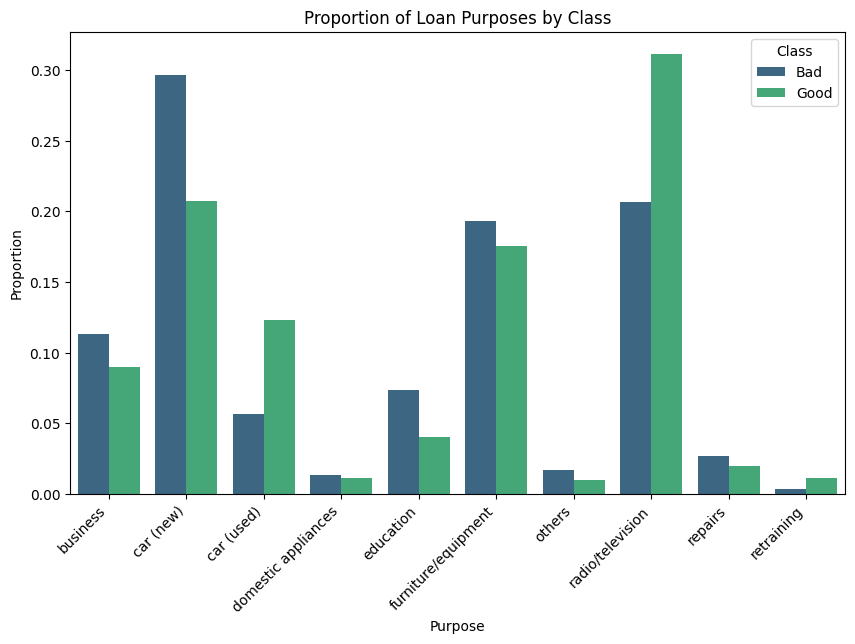

In [17]:
# Normalize the counts within each class to plot proportions 
# Proportion is used because just the counts would be misleading as the classes are imbalanced
plt.figure(figsize=(10, 6))

# Group by Class and Purpose and calculate the proportions
df_grouped = df.groupby(['Class', 'Purpose']).size().reset_index(name='Count')
df_grouped['Proportion'] = df_grouped.groupby('Class')['Count'].transform(lambda x: x / x.sum()) # Proportion within each class

# Plotting the proportions
sns.barplot(x='Purpose', y='Proportion', hue='Class', data=df_grouped, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Proportion of Loan Purposes by Class')
plt.ylabel('Proportion')
plt.show()


**Comparison:**
 
- **Business:** Bad credit applicants have a slightly higher proportion of business loans compared to good credit applicants.
- **Car (New):** A larger proportion of bad credit applicants take out loans for new cars compared to good credit applicants.
- **Car (Used):** Good credit applicants have a significantly higher proportion of used car loans compared to bad credit applicants.
- **Domestic Appliances:** Both classes have a similar, low proportion of loans for domestic appliances.
- **Education:** Bad credit applicants have a higher proportion of education loans compared to good credit applicants.
- **Furniture/Equipment:** The proportion of loans for furniture/equipment is relatively high for both classes, with bad credit applicants having a slightly higher proportion.
- **Others:** The proportion of loans categorized as "others" is low for both classes.
- **Radio/TV:** A significant proportion of good credit applicants take out loans for radio/television, much higher than bad credit applicants.
- **Repairs:** Both classes have a low and similar proportion of loans for repairs.
-**Re-training:** Retraining loans are rare, but they are more common among good credit applicants compared to bad credit applicants.

Notably, bad credit applicants have a higher proportion of loans for new cars, education, and business purposes, while good credit applicants have a higher proportion of loans for used cars and radio/television.

## Task 4 - EDA, Preprocessing
In this task, the dataset will be Preprocessed and than analyzed to see how the data has changed after preprocessing.

### Problematic Features

The dataset contains several three features that I think could be problematic in terms of discrimination and bias:

- **Age_in_years:** Age is a sensitive attribute and could lead to age discrimination. On the other hand the age is a legitimate factor to consider in credit risk assessment, because high age could lead to higher risk of death before the credit is paid back. Therefore, this column will be kept in the dataset.

- **Foreign_worker:** This column indicates whether the applicant is a foreign worker, which could lead to discrimination based on nationality. Therfore it will be removed from the dataset.

- **Personal_status_and_sex:** This column combines personal status and sex, which could introduce gender bias into the model. Therfore it be removed from the dataset.

In [18]:
# Drop columns because of discriminatory concerns
df.drop(columns=["Personal_status_and_sex", "Foreign_worker"], inplace=True)
df.shape

(1000, 19)

After removing Personal_status and Foreign_worker the dataset remains with 19 features.

### Encoding Categorical Variables
Dummy variables will be created for the categorical variables.

In [19]:
# Encoding categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True) 
df_encoded.shape

(1000, 45)

After dummy encoding the categorical columns, the dataset contains 45 features.

### Separating the Target Variable

In [20]:
# Separating features and target variable
X = df_encoded.drop('Class_Good', axis=1)  # 'Class_Good' is the target variable after encoding
y = df_encoded['Class_Good']

### Split the Data

In [21]:
# Split data into train (42%), validation (18%), and test (40%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=random_seed)
# From the remaining 60%, the validation set should be 18% of the total, therefore the validation set size need to be set to 0.18/0.6 = 0.3!!!!
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.30, shuffle=True, random_state=random_seed)

### Scale the data
Only x is scaled, since the y values are binary and do not need to be scaled.

In [22]:
# Initialize the min-max scaler
x_scaler = MinMaxScaler()

In [23]:
# Fit and transform the features
x_scaler.fit(X_train_full)
X_train_sc = x_scaler.transform(X_train) 
X_val_sc = x_scaler.transform(X_val)
X_test_sc = x_scaler.transform(X_test)

Ensure that the data is split into the wanted proportions.

In [24]:
# Calculate the size of test, train and val sets and calculate percentage of each
test_size = len(X_test_sc)
train_size = len(X_train_sc)
val_size = len(X_val_sc)

test_size_percent = test_size / (test_size + train_size + val_size) * 100
train_size_percent = train_size / (test_size + train_size + val_size) * 100
val_size_percent = val_size / (test_size + train_size + val_size) * 100

# Print the size of test, train and val sets and percentage of each
print("Test set size: ", test_size)
print("Train set size: ", train_size)
print("Validation set size: ", val_size)
print(f"Test set size percentage: {test_size_percent} %")
print(f"Train set size percentage: {train_size_percent} %")
print(f"Validation set size percentage: {val_size_percent} %")

Test set size:  400
Train set size:  420
Validation set size:  180
Test set size percentage: 40.0 %
Train set size percentage: 42.0 %
Validation set size percentage: 18.0 %


### Dealing with Imbalanced Classes

To deal with the imbalanced classes, the SMOTE (Synthetic Minority Over-sampling Technique) will be used to oversample the minority class (bad credit).
Only the training data will be oversampled, because no data leakage should occur and the evaluation should be done on data the represents a real world distribution.

In [25]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42) # Set random state for reproducibility and leave other parameters as default
X_train_sc_smote, y_train_smote = smote.fit_resample(X_train_sc, y_train)

In [26]:
# Ceck if the distribution of the classes is now balanced
y_train_smote.value_counts()

Class_Good
True     292
False    292
Name: count, dtype: int64

The Classes in the training set are now balanced.
Because new records were created, the properties and distributions will again investigated, by comparing the data before and after SMOTE was applied.

### Compare the Numberical Features of each Class after SMOTE 

#### Compare Duration

In [27]:
# Look at the distribution of the duration in months of each class before and after SMOTE
display(pd.DataFrame({'Duration in Months Before SMOTE': X_train_sc[:,1], 'Class': y_train}).groupby('Class').describe().round(2))
display(pd.DataFrame({'Duration in Months After SMOTE': X_train_sc_smote[:,1], 'Class': y_train_smote}).groupby('Class').describe().round(2))

Duration in Months Before SMOTE                                      \
                                count  mean   std   min   25%   50%   75%   
Class                                                                       
False                           128.0  0.23  0.22  0.02  0.06  0.13  0.32   
True                            292.0  0.16  0.14  0.00  0.06  0.11  0.20   

             
        max  
Class        
False  1.00  
True   0.86

Duration in Months After SMOTE                                          
                               count  mean   std   min   25%   50%   75%   max
Class                                                                         
False                          292.0  0.22  0.20  0.02  0.07  0.13  0.28  1.00
True                           292.0  0.16  0.14  0.00  0.06  0.11  0.20  0.86

Since the data is scaled, the min and max values are not easily interpretable. However, the comparison before and after applying SMOTE shows that the statistical descriptions of the Duration remained mainly the same, except for some slight changes, indicating that the overall data distribution has been preserved.

#### Compare Credit Amount

In [28]:
# Look at the distribution of the amount of credit of each class before and after SMOTE
display(pd.DataFrame({'Credit Amount Before SMOTE': X_train_sc[:,4], 'Class': y_train}).groupby('Class').describe().round(2))
display(pd.DataFrame({'Credit Amount After SMOTE': X_train_sc_smote[:,4], 'Class': y_train_smote}).groupby('Class').describe().round(2))

Credit Amount Before SMOTE                                          
                           count  mean   std   min   25%   50%   75%   max
Class                                                                     
False                      128.0  0.25  0.18  0.02  0.11  0.19  0.32  0.98
True                       292.0  0.31  0.20  0.02  0.14  0.27  0.43  0.91

Credit Amount After SMOTE                                          
                          count  mean   std   min   25%   50%   75%   max
Class                                                                    
False                     292.0  0.24  0.17  0.02  0.12  0.19  0.29  0.98
True                      292.0  0.31  0.20  0.02  0.14  0.27  0.43  0.91

The comparison before and after applying SMOTE shows that the statistical descriptions of the Credit Amount remained mainly the same, indicating the overall data distribution has been preserved.

#### Compare Installment Rate

In [29]:
# Look at the distribution of the installment rate as percentage of disposable income of each class before and after SMOTE
display(pd.DataFrame({'Installment Rate Before SMOTE': X_train_sc[:,5], 'Class': y_train}).groupby('Class').describe().round(2))
display(pd.DataFrame({'Installment Rate After SMOTE': X_train_sc_smote[:,5], 'Class': y_train_smote}).groupby('Class').describe().round(2))

Installment Rate Before SMOTE                                      
                              count  mean   std  min  25%  50%   75%  max
Class                                                                    
False                         128.0  0.13  0.21  0.0  0.0  0.0  0.33  1.0
True                          292.0  0.14  0.20  0.0  0.0  0.0  0.33  1.0

Installment Rate After SMOTE                                      
                             count  mean   std  min  25%  50%   75%  max
Class                                                                   
False                        292.0  0.12  0.19  0.0  0.0  0.0  0.32  1.0
True                         292.0  0.14  0.20  0.0  0.0  0.0  0.33  1.0

The comparison before and after applying SMOTE shows that the statistical descriptions of the Installment Rate remained mainly the same, indicating the overall data distribution has been preserved.

#### Compare Present Residence Since

In [30]:
# Look at the distribution of the present residence since of each class before and after SMOTE
display(pd.DataFrame({'Present Residence Since Before SMOTE': X_train_sc[:,6], 'Class': y_train}).groupby('Class').describe().round(2))
display(pd.DataFrame({'Present Residence Since After SMOTE': X_train_sc_smote[:,6], 'Class': y_train_smote}).groupby('Class').describe().round(2))

Present Residence Since Before SMOTE                                  \
                                     count  mean   std  min  25%  50%  75%   
Class                                                                        
False                                128.0  0.16  0.37  0.0  0.0  0.0  0.0   
True                                 292.0  0.14  0.35  0.0  0.0  0.0  0.0   

            
       max  
Class       
False  1.0  
True   1.0

Present Residence Since After SMOTE                                     
                                    count  mean   std  min  25%  50%  75%  max
Class                                                                         
False                               292.0  0.13  0.32  0.0  0.0  0.0  0.0  1.0
True                                292.0  0.14  0.35  0.0  0.0  0.0  0.0  1.0

The comparison before and after applying SMOTE shows that the statistical descriptions of the Present Residence Since remained mainly the same, indicating the overall data distribution has been preserved.

#### Compare Age

In [31]:
# Look at the distribution of the age in years of each class before and after SMOTE
display(pd.DataFrame({'Age in Years Before SMOTE': X_train_sc[:,2], 'Class': y_train}).groupby('Class').describe().round(2))
display(pd.DataFrame({'Age in Years After SMOTE': X_train_sc_smote[:,2], 'Class': y_train_smote}).groupby('Class').describe().round(2))

Age in Years Before SMOTE                                       
                          count  mean   std  min   25%   50%  75%  max
Class                                                                 
False                     128.0  0.69  0.36  0.0  0.33  1.00  1.0  1.0
True                      292.0  0.63  0.38  0.0  0.33  0.67  1.0  1.0

Age in Years After SMOTE                                       
                         count  mean   std  min   25%   50%  75%  max
Class                                                                
False                    292.0  0.69  0.33  0.0  0.33  0.79  1.0  1.0
True                     292.0  0.63  0.38  0.0  0.33  0.67  1.0  1.0

The comparison before and after applying SMOTE shows that the statistical descriptions of Age in Years remained mainly the same, indicating the overall data distribution has been preserved.

#### Compare Number of Existing Credits

In [32]:
# Look at the distribution of the number of existing credits at this bank of each class before and after SMOTE
display(pd.DataFrame({'Number of Existing Credits Before SMOTE': X_train_sc[:,3], 'Class': y_train}).groupby('Class').describe().round(2))
display(pd.DataFrame({'Number of Existing Credits After SMOTE': X_train_sc_smote[:,3], 'Class': y_train_smote}).groupby('Class').describe().round(2))

Number of Existing Credits Before SMOTE                               \
                                        count  mean   std  min   25%   50%   
Class                                                                        
False                                   128.0  0.61  0.35  0.0  0.33  0.67   
True                                    292.0  0.62  0.37  0.0  0.33  0.67   

                 
       75%  max  
Class            
False  1.0  1.0  
True   1.0  1.0

Number of Existing Credits After SMOTE                               \
                                       count  mean   std  min   25%   50%   
Class                                                                       
False                                  292.0  0.62  0.32  0.0  0.33  0.64   
True                                   292.0  0.62  0.37  0.0  0.33  0.67   

                 
       75%  max  
Class            
False  1.0  1.0  
True   1.0  1.0

The comparison before and after applying SMOTE shows that the statistical descriptions of the Number of Existing Credits remained mainly the same, indicating the overall data distribution has been preserved.

#### Compare Number of Poeple Liable to Pay Maintenance

In [33]:
# Look at the distribution of the number of people being liable to provide maintenance for of each class before and after SMOTE
display(pd.DataFrame({'Number of People Liable to Pay Maintenance Before SMOTE': X_train_sc[:,7], 'Class': y_train}).groupby('Class').describe().round(2))
display(pd.DataFrame({'Number of People  Liable to Pay Maintenance After SMOTE': X_train_sc_smote[:,7], 'Class': y_train_smote}).groupby('Class').describe().round(2))

Number of People Liable to Pay Maintenance Before SMOTE              \
                                                        count  mean   std   
Class                                                                       
False                                              128.0       0.43  0.50   
True                                               292.0       0.19  0.39   

                                
       min  25%  50%  75%  max  
Class                           
False  0.0  0.0  0.0  1.0  1.0  
True   0.0  0.0  0.0  0.0  1.0

Number of People  Liable to Pay Maintenance After SMOTE              \
                                                        count  mean   std   
Class                                                                       
False                                              292.0       0.43  0.48   
True                                               292.0       0.19  0.39   

                                
       min  25%  50%  75%  max  
Class                           
False  0.0  0.0  0.0  1.0  1.0  
True   0.0  0.0  0.0  0.0  1.0

The comparison before and after applying SMOTE shows that the statistical descriptions of the Number of People Liable to Pay Maintenance remained mainly the same, indicating the overall data distribution has been preserved.

### Create Tensors

In [34]:
# Convert to PyTorch tensors
X_train_sc_smote_tens = torch.tensor(X_train_sc_smote, dtype=torch.float32)
y_train_smote_tens = torch.tensor(y_train_smote.values, dtype=torch.long)
X_val_sc_tens = torch.tensor(X_val_sc, dtype=torch.float32)
y_val_tens = torch.tensor(y_val.values, dtype=torch.long)
X_test_sc_tens = torch.tensor(X_test_sc, dtype=torch.float32)
y_test_tens = torch.tensor(y_test.values, dtype=torch.long)

Ensure that the tensors are created with the correct dimensions.

In [35]:
# Check the sizes of the tensors
print("Train set size:", X_train_sc_smote_tens.size(), y_train_smote_tens.size())
print("Validation set size:", X_val_sc_tens.size(), y_val_tens.size())
print("Test set size:", X_test_sc_tens.size(), y_test_tens.size())

Train set size: torch.Size([584, 44]) torch.Size([584])
Validation set size: torch.Size([180, 44]) torch.Size([180])
Test set size: torch.Size([400, 44]) torch.Size([400])


After SMOTE the size of the training set increased from 400 to 584. Because now the Bad class is oversampled from 108 to 292. 

### Set up data loaders

Since the Dataset is small, the batch size is set to the size of the the corresponding dataset (Train, Val or Test). So the DataLoader will only return one batch of data, and is therefore not really needed. However, the DataLoader is used to show how it would be done correctly for larger datasets.

In [36]:
# Create TensorDatasets for neural networks
train_dataset = TensorDataset(X_train_sc_smote_tens, y_train_smote_tens)
val_dataset = TensorDataset(X_val_sc_tens, y_val_tens)
test_dataset = TensorDataset(X_test_sc_tens, y_test_tens)

# Create DataLoaders for neural networks 
batch_size_train = len(train_dataset)   # Use full batch since the dataset is small 
batch_size_val = len(val_dataset)       # Use full batch since the dataset is small
batch_size_test = len(test_dataset)     # Use full batch since the dataset is small

# Set up the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

## Task 5 -Baseline

In [37]:
# Dataframe to store the results
df_results =  pd.DataFrame()

# # Function evaluate the performance of a classifier
def add_results_to_df(df_results, model, dataset, y_true, y_pred):
    '''
    Function to add the results of a model to a dataframe
    Args:
        df_results : DataFrame : a dataframe to store the results
        model : str : the name of the model
        dataset : str : the name of the dataset (train, test)
        y_true : array : the true labels
        y_pred : array : the predicted labels
    Returns:
        DataFrame : the dataframe with the added results
    '''
    df_results = pd.concat([df_results, pd.DataFrame([{
        "Model": model, 
        "Dataset": dataset,
        "Accuracy": ms.accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1_Score": f1_score(y_true, y_pred),
        "Confusion_Matrix": confusion_matrix(y_true, y_pred)
    }])], ignore_index=True)
    return df_results

### First Baseline (Simple Model)

For the simple baseline model, **DummyClassifier** is used with the strategy set to 'most_frequent'. This strategy predicts the most frequent class in the training data, which is the good credit class.
The dummy classifier is fitted on the training data with imbalanced classes, so the model will predict the majority class (good credit) for all instances.

In [38]:
# Simple baseline using the most frequent class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_train_pred_dummy = dummy_clf.predict(X_train_sc) 
y_test_pred_dummy = dummy_clf.predict(X_test_sc)

# Evaluate the simple baseline and add results to the dataframe
df_results = add_results_to_df(df_results, "DummyClassifier", "train", y_train, y_train_pred_dummy)
df_results = add_results_to_df(df_results, "DummyClassifier", "test", y_test, y_test_pred_dummy)


### Second Baseline (Classical ML Model)

The second baseline model is **Random Forest Classifier** is used with the default hyperparameters.

In [39]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=random_seed)

# Train the Random Forest with the SMOTE-resampled data
rf.fit(X_train_sc_smote, y_train_smote)

# Predict with the pipeline
y_train_pred_rf = rf.predict(X_train_sc_smote)
y_test_pred_rf = rf.predict(X_test_sc)

# Evaluate the Random Forest baseline with SMOTE and add results to the dataframe
df_results = add_results_to_df(df_results, "RandomForest", "train", y_train_smote, y_train_pred_rf)
df_results = add_results_to_df(df_results, "RandomForest", "test", y_test, y_test_pred_rf)

### Evaluation of Baseline Models

In [40]:
# Select results without confusion matrix
df_results_filtered = df_results[['Model', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'F1_Score']]

# Display Test results
display(df_results_filtered[df_results_filtered['Dataset'] == 'test'].sort_values('Accuracy', ascending=False).round(2))

# Display Train results 
display(df_results_filtered[df_results_filtered['Dataset'] == 'train'].sort_values('Accuracy', ascending=False).round(2))

,Model,Dataset,Accuracy,Precision,Recall,F1_Score
3,RandomForest,test,0.76,0.81,0.87,0.84
1,DummyClassifier,test,0.70,0.70,1.00,0.83


,Model,Dataset,Accuracy,Precision,Recall,F1_Score
2,RandomForest,train,1.0,1.0,1.0,1.00
0,DummyClassifier,train,0.7,0.7,1.0,0.82


The Random Forest classifier significantly outperforms the Dummy Classifier with on the test set, demonstrating its ability to capture patterns in the data that the Dummy Classifier misses. However, the perfect scores on the training set indicate potential overfitting, which should be addressed in future steps. The Dummy Classifier provides a useful baseline and achieved an accuracy of 0.7, which is expected because the percentage of the majority class (good) is 70 percent in the complete dataset.

In [41]:
def plot_confusion_matrices(df_results, models):
    """
    Plot confusion matrices for each model in the evaluation results DataFrame.

    Args:
        df_results (DataFrame): DataFrame containing the evaluation results, including confusion matrices.
        models (list): List of model names to plot confusion matrices for.
    Returns:
        None
    """
    
    num_models = len(models) // 2

    # Initialize subplots
    fig, ax = plt.subplots(num_models, 2, figsize=(15, 5 * num_models))

    # Flatten the axes array for easier iteration
    ax = ax.flatten()

    # Plot confusion matrices for each model
    for ax, model in zip(ax, models):
        
        # Get the confusion matrix for the model and dataset (test)
        conf_matrix = df_results.loc[
            (df_results['Model'] == model) & (df_results['Dataset'] == 'test'),
            'Confusion_Matrix'
        ].values[0]

        # Plot the confusion matrix
        ms.ConfusionMatrixDisplay(conf_matrix).plot(ax=ax, colorbar=True)
        ax.set_title(f'{model}')
        ax.set_xticklabels(['Bad', 'Good'])
        ax.set_yticklabels(['Bad', 'Good'])

    # Set the title for the figure
    fig.suptitle('Confusion Matrix for All Models', fontsize=15)
    plt.show()

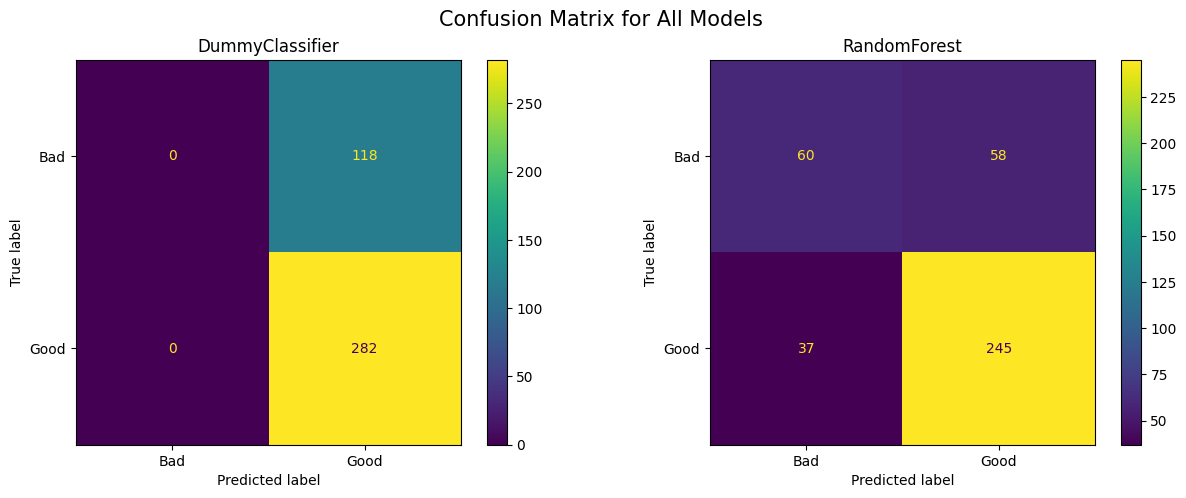

In [42]:
# Plot the confusion matrices of the test set
plot_confusion_matrices(df_results, ['DummyClassifier', 'RandomForest'])

The confusion matrix for the Dummy Classifier shows it predicts all samples as 'good', resulting to a recall of 1 but lead to a poor precision, as it misclassifies all actual 'bad' cases as 'good'.

The Random Forest's confusion matrix indicates better performance, correctly identifying 60 out of 118 'bad' cases and 245 out of 282 'good' cases. While it still misclassifies some cases, it shows a more balanced approach. 
 
It is more critical to avoid classifying bad applicants as good, as this represents a higher risk to the bank. The Random Forest's ability to better distinguish these cases makes it a more effective model.

## Task 6 – Deep Learning Experiments

#### Define Model Architecture

The fist from the two alternatives in Task 6 is conducted. 

(1. Choose at least one of the architectures such that it contains layers or cells beyond simple
linear layers and activation functions)

#### Model 1: Simple Feedforward Neural Network (SimpleNN)

In [43]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        # Initialize the input size
        self.input_size = input_size
        
        # Define the layers
        self.lin1 = nn.Linear(input_size, 256)  # First hidden layer with 256 neurons
        self.lin2 = nn.Linear(256, 128)         # Second hidden layer with 128 neurons
        self.lin3 = nn.Linear(128, 64)          # Third hidden layer with 64 neurons
        self.lin4 = nn.Linear(64, 32)           # Fourth hidden layer with 32 neurons
        self.lin5 = nn.Linear(32, 16)           # Fifth hidden layer with 16 neurons
        self.lin6 = nn.Linear(16, 1)            # Output layer with 1 neuron for binary classification

    def forward(self, x):
        # Apply ReLU activation function after each hidden layer
        x = torch.relu(self.lin1(x))  # First hidden layer
        x = torch.relu(self.lin2(x))  # Second hidden layer
        x = torch.relu(self.lin3(x))  # Third hidden layer
        x = torch.relu(self.lin4(x))  # Fourth hidden layer
        x = torch.relu(self.lin5(x))  # Fifth hidden layer
        x = self.lin6(x)              # Output layer (no activation function here because it's handled in loss function)
        return x  # Return raw logits

    def predict(self, x):
        # Predict the class with the highest logit score
        logits = self.forward(x)       # Forward pass to get logits
        probs = torch.sigmoid(logits)  # Convert logits to probabilities
        return (probs > 0.5).float()   # Return 0 or 1 based on probability


#### Model 2: Feedforward Neural Network with Dropout (DropoutNN)

In [44]:
class DropoutNN(nn.Module):
    def __init__(self, input_size):
        super(DropoutNN, self).__init__()
        # Initialize the input size
        self.input_size = input_size
        
        # Define the layers with dropout for regularization
        self.lin1 = nn.Linear(input_size, 256)  # First hidden layer with 256 neurons
        self.dropout1 = nn.Dropout(0.5)         # Dropout after first hidden layer
        self.lin2 = nn.Linear(256, 128)         # Second hidden layer with 128 neurons
        self.dropout2 = nn.Dropout(0.5)         # Dropout after second hidden layer
        self.lin3 = nn.Linear(128, 64)          # Third hidden layer with 64 neurons
        self.dropout3 = nn.Dropout(0.5)         # Dropout after third hidden layer
        self.lin4 = nn.Linear(64, 32)           # Fourth hidden layer with 32 neurons
        self.dropout4 = nn.Dropout(0.5)         # Dropout after fourth hidden layer
        self.lin5 = nn.Linear(32, 16)           # Fifth hidden layer with 16 neurons
        self.dropout5 = nn.Dropout(0.5)         # Dropout after fifth hidden layer
        self.lin6 = nn.Linear(16, 1)            # Output layer with 1 neuron for binary classification

    def forward(self, x):
        # Apply ReLU activation function and dropout after each hidden layer
        x = torch.relu(self.lin1(x))  # First hidden layer
        x = self.dropout1(x)          # Apply dropout
        x = torch.relu(self.lin2(x))  # Second hidden layer
        x = self.dropout2(x)          # Apply dropout
        x = torch.relu(self.lin3(x))  # Third hidden layer
        x = self.dropout3(x)          # Apply dropout
        x = torch.relu(self.lin4(x))  # Fourth hidden layer
        x = self.dropout4(x)          # Apply dropout
        x = torch.relu(self.lin5(x))  # Fifth hidden layer
        x = self.dropout5(x)          # Apply dropout
        x = self.lin6(x)              # Output layer (no activation function here because it's handled in loss function)
        return x  # Return raw logits

    def predict(self, x):
        # Predict the class with the highest logit score
        logits = self.forward(x)       # Forward pass to get logits
        probs = torch.sigmoid(logits)  # Convert logits to probabilities
        return (probs > 0.5).float()   # Return 0 or 1 based on probability


#### Use CPU

In [45]:
# Set device to CPU 
device = torch.device("cpu")

#### Function for Training 

In [46]:
def train_model(model, model_name, learning_rate, criterion, epochs, train_loader, val_loader, patience=10, improvement_threshold=0.001):
    """
    Train a neural network model and use early stopping based on validation loss.

    Args:
        model (nn.Module): The neural network model to train.
        model_name (str): The name of the model, used for logging.
        learning_rate (float): Learning rate for the optimizer.
        criterion (nn.Module): Loss function.
        epochs (int): Number of epochs to train the model.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        patience (int): Number of epochs to wait for improvement before stopping early.
        improvement_threshold (float): Minimum improvement required to reset the patience counter.

    Returns:
        model (nn.Module): The best model based on validation accuracy.
        best_loss_val (float): The best validation loss achieved.
        best_accuracy_val (float): The best validation accuracy achieved.
        best_epoch (int): The epoch number with the best validation accuracy.
    """
    
    # Initialize variables to track the best model state and corresponding metrics
    best_accuracy_val = float('-inf')  # Best validation accuracy initialized to negative infinity
    best_loss_val = float('inf')       # Best validation loss initialized to positive infinity
    best_model_state = copy.deepcopy(model.state_dict())  # Deepcopy to save the best model state
    patience_counter = 0               # Counter for early stopping
    best_epoch = 0                     # Epoch at which the best model was obtained

    # Set up TensorBoard writer for logging training and validation metrics
    writer = SummaryWriter()
    
    # Initialize optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        
        model.train()         # Set the model to training mode
        running_loss = 0.0    # Accumulate the training loss
        running_corrects = 0  # Accumulate the number of correct predictions

        # Iterate over batches of training data 
        # (Full batch is used because of the small dataset so just one iteration is done)
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)   # Move inputs and labels to the device (GPU/CPU)
            y_train_pred = model(inputs).squeeze()                  # Forward pass to get predictions
            loss_train = criterion(y_train_pred, labels.float())    # Compute the training loss

            optimizer.zero_grad()  # Zero the gradients
            loss_train.backward()  # Backward pass to compute gradients
            optimizer.step()       # Update the model parameters

            running_loss += loss_train.item() * inputs.size(0)   # Accumulate the batch loss
            preds = (torch.sigmoid(y_train_pred) > 0.5).float()  # Convert logits to binary predictions
            running_corrects += torch.sum(preds == labels.data)  # Accumulate the number of correct predictions

        # Calculate training loss and accuracy for the epoch
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset) 

        # Set the model to evaluation mode for validation
        model.eval()
        val_loss = 0.0  # Accumulate the validation loss
        val_corrects = 0  # Accumulate the number of correct predictions

        # Disable gradient calculation for validation
        with torch.no_grad():
            # Iterate over batches of validation data
            # (Full batch is used because of the small dataset so just one iteration is done)
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)   # Move inputs and labels to the device
                y_pred_val = model(inputs).squeeze()                    # Forward pass to get predictions
                loss_val = criterion(y_pred_val, labels.float())        # Compute the validation loss

                val_loss += loss_val.item() * inputs.size(0)        # Accumulate the batch loss
                preds = (torch.sigmoid(y_pred_val) > 0.5).float()   # Convert logits to binary predictions
                val_corrects += torch.sum(preds == labels.data)     # Accumulate the number of correct predictions

        # Calculate validation loss and accuracy for the epoch
        epoch_val_acc = val_corrects.double() / len(val_loader.dataset) # Accuracy = correct predictions / total predictions
        epoch_val_loss = val_loss / len(val_loader.dataset)             # Loss = total loss / total predictions
       
        # Log training and validation metrics to TensorBoard
        writer.add_scalars(f'{model_name} Accuracy', {'train': epoch_train_acc, 'val': epoch_val_acc}, epoch)
        writer.add_scalars(f'{model_name} Loss', {'train': epoch_train_loss, 'val': epoch_val_loss}, epoch)

        # Early stopping based on validation loss
        if epoch_val_loss < best_loss_val - improvement_threshold:
            # If validation loss improves, update best_loss_val and reset patience_counter
            best_loss_val = epoch_val_loss
            patience_counter = 0
        else:
            patience_counter += 1  # Increment patience counter if no significant improvement
                  
        if patience_counter >= patience:
            # Stop training early if no improvement for 'patience' epochs
            print(f"Early stopping at epoch {epoch} due to lack of significant improvement in validation loss")
            break

        # Update the best model based on validation accuracy
        if epoch_val_acc > best_accuracy_val:
            best_accuracy_val = epoch_val_acc                     # Save the best validation accuracy
            best_model_state = copy.deepcopy(model.state_dict())  # Save the model with the best validation accuracy
            best_epoch = epoch                                    # Save the epoch number with the best validation accuracy

        # Print metrics for the first 10 epochs and every 200 epochs thereafter
        if epoch < 10 or epoch % 200 == 199:
            print(f"Epoch: {epoch}, Train Loss: {epoch_train_loss:.5f}, Val Loss: {epoch_val_loss:.5f}, Train Accuracy: {epoch_train_acc:.5f}, Val Accuracy: {epoch_val_acc:.5f}")

    writer.close()                           # Close the TensorBoard writer
    model.load_state_dict(best_model_state)  # Load the best model state

    return model, best_loss_val, best_accuracy_val, best_epoch  # Return the best model and corresponding metrics


#### Initialize the Models

In [47]:
# Get input size
input_size = X_train_sc.shape[1]

# Initialize models
model1 = SimpleNN(input_size).to(device)
model2 = DropoutNN(input_size).to(device)

#### Set Hyperparameters

In [48]:
# Loss function
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits Loss

# Learning rate (same learning rate for both models, but usually this is would be tuned separately for each model)
learning_rate_model1 = 0.001 
learning_rate_model2 = 0.001

# Number of epochs
num_epochs = 1000

# Patience for early stopping
patience = 50

# Improvement threshold for early stopping
improvement_threshold = 0.001

#### Training the SimpleNN Model

In [49]:
# Train SimpleNN model
print("Training SimpleNN model with full-batch gradient descent")
model1, best_loss1, best_acc1, best_epoch1 = train_model(
    model=model1,                                           # Model to train
    model_name="SimpleNN",                                  # Model name
    learning_rate=learning_rate_model1,                     # Learning rate
    criterion=nn.BCEWithLogitsLoss(),                       # Loss function
    epochs=num_epochs,                                      # Number of epochs
    train_loader=train_loader,                              # DataLoader for training data
    val_loader=val_loader,                                  # DataLoader for validation data
    patience=patience,                                      # Patience for early stopping
    improvement_threshold=improvement_threshold             # Improvement threshold for early stopping
)

Training SimpleNN model with full-batch gradient descent
Epoch: 0, Train Loss: 0.69351, Val Loss: 0.68264, Train Accuracy: 0.50000, Val Accuracy: 0.70000
Epoch: 1, Train Loss: 0.69303, Val Loss: 0.68302, Train Accuracy: 0.50000, Val Accuracy: 0.70000
Epoch: 2, Train Loss: 0.69253, Val Loss: 0.68321, Train Accuracy: 0.50000, Val Accuracy: 0.70000
Epoch: 3, Train Loss: 0.69193, Val Loss: 0.68304, Train Accuracy: 0.50000, Val Accuracy: 0.70000
Epoch: 4, Train Loss: 0.69114, Val Loss: 0.68265, Train Accuracy: 0.50000, Val Accuracy: 0.70000
Epoch: 5, Train Loss: 0.69015, Val Loss: 0.68204, Train Accuracy: 0.50000, Val Accuracy: 0.70000
Epoch: 6, Train Loss: 0.68893, Val Loss: 0.68127, Train Accuracy: 0.50000, Val Accuracy: 0.70000
Epoch: 7, Train Loss: 0.68746, Val Loss: 0.68027, Train Accuracy: 0.50000, Val Accuracy: 0.70556
Epoch: 8, Train Loss: 0.68576, Val Loss: 0.67890, Train Accuracy: 0.51541, Val Accuracy: 0.74444
Epoch: 9, Train Loss: 0.68375, Val Loss: 0.67706, Train Accuracy: 0.61

In [50]:
# Look at best loss, best accuracy, and best epoch
print(f"Best validation loss: {best_loss1:.2f}")
print(f"Best validation accuracy: {best_acc1:.2f}")
print(f"Best epoch: {best_epoch1}")

Best validation loss: 0.52
Best validation accuracy: 0.74
Best epoch: 8


The best validation accuracy was achieved in epoch 8, reaching 0.74. The best validation loss achieved was 0.52, which does not necessarily correspond to the epoch with the best validation accuracy. The TensorBoard plot shown later in the notebook indicates that the best validation loss was around epoch 48. Based on these results, a similar accuracy on the test set is expected.

#### Training the DropoutNN Model

In [51]:
# Train DropoutNN model
print("Training DropoutNN model with full-batch gradient descent")
model2, best_loss2, best_acc2, best_epoch2 = train_model(
    model=model2,                                           # Model to train
    model_name="DropoutNN",                                 # Model name
    learning_rate=learning_rate_model2,                     # Learning rate
    criterion=nn.BCEWithLogitsLoss(),                       # Loss function
    epochs=num_epochs,                                      # Number of epochs
    train_loader=train_loader,                              # DataLoader for training data
    val_loader=val_loader,                                  # DataLoader for validation data
    patience=patience,                                      # Patience for early stopping
    improvement_threshold=improvement_threshold             # Improvement threshold for early stopping
)

Training DropoutNN model with full-batch gradient descent
Epoch: 0, Train Loss: 0.69436, Val Loss: 0.67466, Train Accuracy: 0.50000, Val Accuracy: 0.70000
Epoch: 1, Train Loss: 0.69501, Val Loss: 0.67524, Train Accuracy: 0.50514, Val Accuracy: 0.70000
Epoch: 2, Train Loss: 0.69548, Val Loss: 0.67585, Train Accuracy: 0.48459, Val Accuracy: 0.70000
Epoch: 3, Train Loss: 0.69544, Val Loss: 0.67647, Train Accuracy: 0.49829, Val Accuracy: 0.70000
Epoch: 4, Train Loss: 0.69419, Val Loss: 0.67710, Train Accuracy: 0.53253, Val Accuracy: 0.70000
Epoch: 5, Train Loss: 0.69534, Val Loss: 0.67773, Train Accuracy: 0.50000, Val Accuracy: 0.70000
Epoch: 6, Train Loss: 0.69234, Val Loss: 0.67837, Train Accuracy: 0.51712, Val Accuracy: 0.70000
Epoch: 7, Train Loss: 0.69424, Val Loss: 0.67899, Train Accuracy: 0.51541, Val Accuracy: 0.70000
Epoch: 8, Train Loss: 0.69352, Val Loss: 0.67963, Train Accuracy: 0.50514, Val Accuracy: 0.70000
Epoch: 9, Train Loss: 0.69512, Val Loss: 0.68018, Train Accuracy: 0.4

In [52]:
# Look at best loss, best accuracy, and best epoch
print(f"Best validation loss: {best_loss2:.2f}")
print(f"Best validation accuracy: {best_acc2:.2f}")
print(f"Best epoch: {best_epoch2}")

Best validation loss: 0.49
Best validation accuracy: 0.79
Best epoch: 122


The best validation accuracy was achieved in epoch 122, reaching 0.79. The best validation loss achieved was 0.49, which does not necessarily correspond to the epoch with the best validation accuracy. The TensorBoard plot shown later in the notebook indicates that the best validation loss was achieved between epochs 80 and 100. Based on these results, a similar accuracy on the test set is expected.

### Tesorboard training progress Plots

The Accuracy and the Loss of the two models where tracked during training via Tensorboard. The plots below show the training and validation accuracy and loss for both models over the epochs.

#### Training and Validation Accuracy of SimpleNN

![title](tensorboard_plots/Accuracy_Simple_NN.png)

During the training of the Simple Neural Network (SimpleNN) model, the accuracy was tracked over the epochs and visualized using TensorBoard. The training process was stopped after 99 epochs due to the lack of significant improvement in the validation loss.

The x-axis of the plot represents the number of epochs, extending up to 99, while the y-axis indicates the accuracy. Two distinct plots are shown: the blue plot represents the training accuracy, and the pink plot represents the validation accuracy.

The training accuracy increased mostly constant throughout the epochs, finaly reaching a value of 1.0, indicating that the model was able to fit the training data almost perfectly. On the other hand, the validation accuracy started at 0.7 and fluctuated mostly slightly above this value, but never exceed 0.8. The final validation accuracy is 0.72, suggesting that while the model performed very well on the training data, its performance on the validation set was moderate, this discrepancy indicates overfitting.

#### Training and Validation Loss of SimpleNN

![title](tensorboard_plots/Loss_SimpleNN.png)

The x-axis represents the number of epochs, extending up to 99, while the y-axis indicates the loss values. Two distinct plots are shown: the yellow plot represents the training loss, and the purple plot represents the validation loss.

Both the training loss and validation loss started around 0.7 and remained equal until approximately epoch 20. From that point onward, the training loss began to decrease constant, reaching a very low value of 0.0041 by epoch 99. This significant reduction in training loss indicates that the model was able to fit the training data very well.

In contrast, the validation loss showed a different trend. It remained relatively constant, slightly above 0.5, until around epoch 60. After that, the validation loss started to increase, reaching 1.1897 by the final epoch. This divergence between the training loss and validation loss suggests that the model was overfitting to the training data. While it was able to minimize the error on the training set, its performance on the validation set worsen, as evidenced by the increasing validation loss.

#### Training and Validation Accuracy of DropoutNN

![title](tensorboard_plots/Accuracy_DropoutNN.png)

The training process for the DropoutNN model was tracked over 145 epochs, stopping early due to a lack of significant improvement in validation loss. 

The orange line represents the training accuracy, which started around 0.5 and steadily increased with many small fluctuations, reaching 0.9503 at the final epoch. The grey line represents the validation accuracy, starting at 0.7 and initially dropping to 0.6 after epoch 20. From epoch 30 onwards, the validation accuracy increased again, fluctuating between 0.7 and just below 0.8, ending at 0.7556. 

This indicates that while the model learned well on the training data, its performance on the validation data showed some variability but ultimately maintained a reasonable level of accuracy. The notable difference between the training and validation accuracies suggests that the model may be overfitting to the training data.

#### Training and Validation Loss of DropoutNN

![title](tensorboard_plots/Loss_DropoutNN.png)

The training process for the DropoutNN model shows the loss over 145 epochs. <br>
The blue line represents the training loss, and the pink line represents the validation loss. Both started around 0.68 and stayed close to each other until about epoch 80, during which they both decreased. After epoch 80, the training loss continued to decrease steadily, reaching a value of 0.15 by the final epoch. However, the validation loss did not decrease further and instead began to increase, reaching 0.77 at the last epoch. 

This divergence between the training and validation losses after epoch 80 further indicates that the model is overfitting, as it continues to improve on the training data while its performance on the validation data worsens.

#### Open Tensorboard inside the Jupyter Notebook
By executing the following cell, the tensorboard can be opened inside the notebook. An the plots from above can be accessed.

In [53]:
# # Launch TensorBoard
# %load_ext tensorboard

# # Sleep for 5 second to allow TensorBoard to load
# time.sleep(5)

# %tensorboard --logdir ./runs

#### Evaluate the Models

In [54]:
def evaluate_model(model, model_name, train_loader, test_loader, df_results, threshold=0.5):
    """
    Evaluate a trained model on both the training and test datasets, and append the results to a DataFrame.

    Args:
        model (nn.Module): The trained PyTorch model to evaluate.
        model_name (str): The name of the model being evaluated (for logging purposes).
        train_loader (DataLoader): DataLoader for the training dataset.
        test_loader (DataLoader): DataLoader for the test dataset.
        df_results (DataFrame): DataFrame to store the evaluation results.
        threshold (float): Threshold for binary classification.

    Returns:
        DataFrame: Updated DataFrame containing the evaluation results.
    """
    
    # Loop over both the training and test phases
    for phase, loader in zip(["train", "test"], [train_loader, test_loader]):
        model.eval()     # Set the model to evaluation mode
        all_preds = []   # List to store all predictions
        all_labels = []  # List to store all true labels
        
        # Iterate over batches of data
        # (Full batch is used so just one iteration is done)
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)    # Move inputs and labels to the appropriate device
            with torch.no_grad():                                    # Disable gradient calculation
                outputs = model(inputs).squeeze()                    # Forward pass through the model
                preds = (torch.sigmoid(outputs) > threshold).float() # Apply sigmoid and threshold
            
            # Collect the predictions and true labels
            all_preds.extend(preds.cpu().numpy())    # Move predictions to CPU and convert to numpy array
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy array
        
        # Add the results to the DataFrame
        df_results = add_results_to_df(df_results, model_name, phase, all_labels, all_preds)
    
    return df_results

In [55]:
# Evaluate SimpleNN model
df_results = evaluate_model(model1, "SimpleNN", train_loader, test_loader, df_results)

# Evaluate DropoutNN model
df_results = evaluate_model(model2, "DropoutNN", train_loader, test_loader, df_results)

In [56]:
# Select results without confusion matrix
df_results_filtered = df_results[['Model', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'F1_Score']]

In [57]:
# Display Test results
display(df_results_filtered[df_results_filtered['Dataset'] == 'test'].sort_values('Accuracy', ascending=False).round(2))

# Display Train results 
display(df_results_filtered[df_results_filtered['Dataset'] == 'train'].sort_values('Accuracy', ascending=False).round(2))

,Model,Dataset,Accuracy,Precision,Recall,F1_Score
3,RandomForest,test,0.76,0.81,0.87,0.84
7,DropoutNN,test,0.75,0.81,0.85,0.83
5,SimpleNN,test,0.75,0.75,0.97,0.84
1,DummyClassifier,test,0.70,0.70,1.00,0.83


,Model,Dataset,Accuracy,Precision,Recall,F1_Score
2,RandomForest,train,1.00,1.00,1.00,1.00
6,DropoutNN,train,0.96,0.96,0.97,0.96
0,DummyClassifier,train,0.70,0.70,1.00,0.82
4,SimpleNN,train,0.62,0.57,0.95,0.71


**Interpretation and Insights**

**SimpleNN:** The Simple Neural Network shows a moderate performance with an accuracy of 0.75 on the test set. The high recall (0.97) on the test set indicates that the model is very sensitive to detecting bad credit but at the cost of precision (0.75). The training accuracy (0.62) and precision (0.57) are much lower, reinforcing the impression of overfitting observed in the TensorBoard plots.

**DropoutNN:** The Dropout Neural Network also achieves an accuracy of 0.75 on the test set but with a better balance of precision (0.81) and recall (0.85). The inclusion of dropout layers helps mitigate overfitting, as seen by the training accuracy of 0.96, which is high but not perfect. The test performance is more consistent with the training performance, indicating better generalization compared to the SimpleNN.

**Key Observations**

The **Random Forest** and **DropoutNN** models exhibit better generalization capabilities compared to the SimpleNN.<br>
The **DropoutNN** provides a good trade-off between high recall and reasonable precision, making it a balanced choice for the credit risk assessment task.<br>
The **SimpleNN's** high recall on the test set suggests it is good at identifying bad credit but suffers from low precision and overfitting issues, as indicated by the TensorBoard plots.<br>
The **DummyClassifier** serves as a baseline to highlight the improvement achieved by more sophisticated models.<br>

Overall, while the DropoutNN shows promise with balanced performance, further tuning and validation are required to ensure robust generalization and to mitigate overfitting, especially for models like the Random Forest.


#### Look at the Confusion Matrix

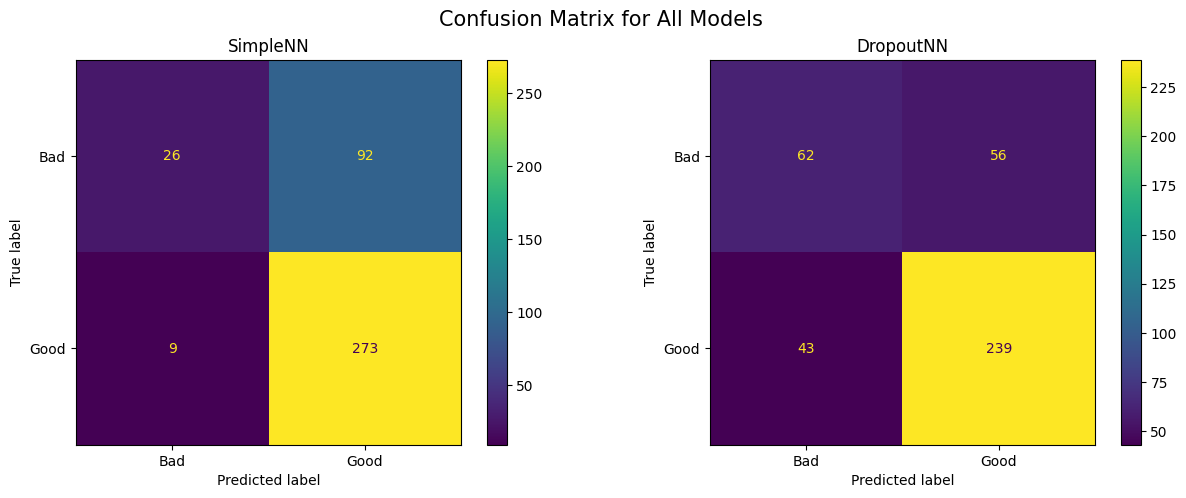

In [59]:
# Assuming df_results contains the evaluation results including confusion matrices
plot_confusion_matrices(df_results,  ['SimpleNN', 'DropoutNN'])

**SimpleNN:**
- The SimpleNN has a high number of false positives (92), which means it incorrectly classifies a significant number of bad applicants as good. This is critical as it represents a high risk to the bank by potentially granting loans to individuals who may default.
- The number of false negatives (9) is lower compared to false positives, but given the imbalance in the test set (more good applicants), this number might still represent a substantial number of good applicants being incorrectly classified as bad.

**DropoutNN:**
- The DropoutNN model shows a better performance in reducing false positives (56) compared to SimpleNN, meaning it classifies fewer bad applicants as good, thus mitigating the bank's risk.
- However, it has a higher number of false negatives (43) compared to SimpleNN, which means more good applicants are incorrectly classified as bad and might be denied loans.

**Conclusion:**

- The DropoutNN model performs better in avoiding the critical error of classifying bad applicants as good, thus posing less risk to the bank compared to the SimpleNN model.
- Although the DropoutNN model has a higher number of false negatives, which could result in missed opportunities by denying good applicants, this is less risky than granting loans to potentially bad applicants who may default.
- Overall, the DropoutNN model strikes a better balance between minimizing risk and maintaining accuracy. This is particularly important in the context of imbalanced datasets, where the cost of misclassification must be carefully considered.

    add comparison with random forest?

## Task 7 – Conclusions and Future Work

    No interpretation/reson why someone get the credit or not. further work use lime. 

    It is worse to class a customer as good when they are bad, than it is to class a customer as bad when they are good.
    dropout value should be optimized

    old data 

    

**Note**: This experiment was created with the help of ChatGPT and the GitHub Copilot.

    
    Check if comparisong after smote the correct fdeatures are selected because only the column number is used.